In [1]:
# Installing 
!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet
!pip install -q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.4 MB/s eta 0:00:00
  

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text


from transformers import T5Tokenizer, TFT5Model, TFT5ForConditionalGeneration, TFT5EncoderModel

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import transformers

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.2.152.26:8470']


In [4]:
#@title Plotting Function

# 2-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history,  
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower = np.min(model_history.history[metric]) * 0.9

        y_lim_upper = np.max(model_history.history[metric]) * 1.1

        ax1 = axs[i]
        ax1.plot(model_history.history[metric])
        ax1.plot(model_history.history['val_%s' % metric])
        ax1.set_ylabel(metric, bbox=box)
        ax1.set_ylim(y_lim_lower, y_lim_upper)

In [5]:
import pandas as pd
# Load the LIAR-PLUS dataset
from google.colab import files
uploaded = files.upload()


Saving final_liar_features.csv to final_liar_features.csv


In [6]:
import io
liar_plus_dataset = pd.read_csv(io.BytesIO(uploaded['final_liar_features.csv']))
# Dataset is now stored in a Pandas Datafram

In [7]:
# Remove punctuation (so as not to confuse t5) and check unique labels
liar_plus_dataset['label'] = liar_plus_dataset['label'].apply(lambda x: x.replace('-', ' '))
liar_plus_dataset['label'].unique()

array(['false', 'half true', 'mostly true', 'true', 'barely true',
       'pants fire'], dtype=object)

In [8]:
liar_plus_dataset['label_num'].unique()

array([1, 3, 4, 5, 2, 0])

In [9]:
# Confirm that the label nums are assigned correctly and check the distribution
liar_plus_dataset.groupby(['label_num', 'label']).size()

label_num  label      
0          pants fire     1050
1          false          2511
2          barely true    2108
3          half true      2638
4          mostly true    2466
5          true           2063
dtype: int64

In [10]:
# Create a binary label (should be text for t5) and confirm this was done correctly
liar_plus_dataset['binary_label'] = np.where(liar_plus_dataset['binary_label_num'] == 1, 'false', 'true')
liar_plus_dataset.groupby(['binary_label', 'label']).size()

binary_label  label      
false         barely true    2108
              false          2511
              pants fire     1050
true          half true      2638
              mostly true    2466
              true           2063
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

# Load the LIAR Plus dataset from a CSV file
df = liar_plus_dataset

In [12]:
# convert the label to string for T5 - need them to be uniform lengths as a string
df['label_num'] = df['label_num'].astype(str)
# Using 0 as a string gives a length of 3, we need all labels to have uniform length (padding with - 0s causes odd training behavior)
## Change the label 0 to a label of 6
df['label_num'] = df['label_num'].replace({'0':'6'})
# Check the assignment looks ok
df.groupby(['label_num', 'label']).size()
# Good - pants on fire is now assigned to 6

label_num  label      
1          false          2511
2          barely true    2108
3          half true      2638
4          mostly true    2466
5          true           2063
6          pants fire     1050
dtype: int64

Data Preparation

In [13]:
# Pre-processing steps of the input claim for T5 classification task

def prep_for_t5(input_claim):
  # pre-pend the data with the task: since we're not using one of T5's built in tasks we can just make up our own
  input_claim = 'truthfulness: ' + input_claim
  return input_claim


# Apply to the dataset

# Claim is the original claim on its own
df['claim'] = df['claim'].apply(prep_for_t5)

# Combined text is the claim + concatenated metadata
df['combined_text'] = df['combined_text'].apply(prep_for_t5)
df


,id,label,label_num,binary_label_num,ternary_label_num,claim,combined_text,fear,anger,anticipation,...,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji,combined_pos,binary_label
0,0,false,1,1,2,truthfulness: Says the Annies List political g...,truthfulness: Says the Annies List political g...,0.166667,0.166667,0.000000,...,18.75,6.25,0.00,0.00,0.0,0.00,12.50,0,Says the Annies List political group supports ...,false
1,1,half true,3,0,1,truthfulness: When did the decline of coal sta...,truthfulness: When did the decline of coal sta...,0.000000,0.000000,0.250000,...,22.58,6.45,0.00,3.23,0.0,0.00,12.90,0,When did the decline of coal start? It started...,true
2,2,mostly true,4,0,0,"truthfulness: ""Hillary Clinton agrees with Joh...","truthfulness: ""Hillary Clinton agrees with Joh...",0.200000,0.000000,0.000000,...,39.13,4.35,0.00,0.00,0.0,0.00,34.78,0,"""Hillary Clinton agrees with John McCain """"by ...",true
3,3,false,1,1,2,truthfulness: Health care reform legislation i...,truthfulness: Health care reform legislation i...,0.166667,0.000000,0.166667,...,21.43,7.14,0.00,0.00,0.0,0.00,14.29,0,Health care reform legislation is likely to ma...,false
4,4,half true,3,0,1,truthfulness: The economic turnaround started ...,truthfulness: The economic turnaround started ...,0.000000,0.000000,0.000000,...,14.29,7.14,0.00,0.00,0.0,0.00,7.14,0,The economic turnaround started at the end of ...,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12831,1279,half true,3,0,1,truthfulness: For the first time in more than ...,truthfulness: For the first time in more than ...,0.000000,0.000000,0.500000,...,23.08,3.85,3.85,0.00,0.0,0.00,15.38,0,"For the first time in more than a decade, impo...",true
12832,1280,mostly true,4,0,0,truthfulness: Says Donald Trump has bankrupted...,truthfulness: Says Donald Trump has bankrupted...,0.000000,0.000000,0.000000,...,20.00,5.00,5.00,0.00,0.0,0.00,10.00,0,Says Donald Trump has bankrupted his companies...,true
12833,1281,true,5,0,0,"truthfulness: ""John McCain and George Bush hav...","truthfulness: ""John McCain and George Bush hav...",0.000000,0.000000,1.000000,...,72.22,16.67,5.56,0.00,0.0,0.00,50.00,0,"""John McCain and George Bush have """"absolutely...",true
12834,1282,false,1,1,2,truthfulness: A new poll shows 62 percent supp...,truthfulness: A new poll shows 62 percent supp...,0.000000,0.000000,0.375000,...,26.47,14.71,0.00,0.00,0.0,2.94,8.82,0,A new poll shows 62 percent support the presid...,false


In [14]:
# Will need to tokenize the labels for T5 as well - check the lengths so we can pad appropriately
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [15]:
# What is the max length of any of our tokenizers?
t5_tokenizer(list(df['label_num'].unique()))
# Good - all are 2

{'input_ids': [[209, 1], [220, 1], [314, 1], [305, 1], [204, 1], [431, 1]], 'attention_mask': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]}

In [16]:
# What about binary?
t5_tokenizer(list(df['binary_label'].unique()))
# Looks like it's 2 - good

{'input_ids': [[6136, 1], [1176, 1]], 'attention_mask': [[1, 1], [1, 1]]}

In [29]:
train, val, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

In [30]:
# Convert to dictionary for easier processing into tensorflow dataset
train = train.to_dict('records')
val = val.to_dict('records')
test = test.to_dict('records')

In [31]:
# Encode the dataset
def encode(example, input_col,
           encoder_max_len, decoder_max_len, is_binary):
  
    claim = example[input_col]
    if is_binary:
      label = example['binary_label']
    else:
      label = example['label_num']
    
    encoder_inputs = t5_tokenizer(claim, return_tensors='tf', max_length=encoder_max_len, padding='max_length', truncation=True)
    
    decoder_inputs = t5_tokenizer(label, return_tensors='tf', max_length=decoder_max_len, padding='max_length', truncation=True)

    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention}
    return outputs

In [32]:
# organize the inputs as a dictionary to convert to a tf dataset
six_way_train = [encode(x, input_col = 'claim', encoder_max_len = 512, decoder_max_len = 2, is_binary = False) for x in train]
binary_train = [encode(x, input_col = 'claim', encoder_max_len = 512, decoder_max_len = 2, is_binary = True) for x in train]
six_way_val = [encode(x, input_col = 'claim', encoder_max_len = 512, decoder_max_len = 2, is_binary = False) for x in val]
binary_val = [encode(x, input_col = 'claim', encoder_max_len = 512, decoder_max_len = 2, is_binary = True) for x in val]
six_way_test = [encode(x, input_col = 'claim', encoder_max_len = 512, decoder_max_len = 2, is_binary = False) for x in test]
binary_test = [encode(x, input_col = 'claim', encoder_max_len = 512, decoder_max_len = 2, is_binary = True) for x in test]

In [33]:
# Convert to tf dataset

# Code borrowed from https://colab.research.google.com/github/snapthat/TF-T5-text-to-text/blob/master/snapthatT5/notebooks/TF-T5-Datasets%20Training.ipynb#scrollTo=TJVLbHbelMki
# and drew inspiration from https://stackoverflow.com/questions/68567630/converting-a-list-of-dictionaries-to-a-tf-dataset
def to_tf_dataset(dataset):
  input_ids = tf.data.Dataset.from_tensor_slices([d['input_ids'] for d in dataset])
  input_attention = tf.data.Dataset.from_tensor_slices([d['attention_mask'] for d in dataset])
  labels = tf.data.Dataset.from_tensor_slices([d['labels'] for d in dataset])
  decoder_attention_mask = tf.data.Dataset.from_tensor_slices([d['decoder_attention_mask'] for d in dataset])
  ds = tf.data.Dataset.zip((input_ids, input_attention, labels, decoder_attention_mask))
  ds = ds.map(lambda x, y, z, l: {"input_ids": x, "attention_mask": y,
                                "labels": z, "decoder_attention_mask": l})
  return ds

In [34]:
# 4 datasets - train/test for six way and binary classification tasks
six_way_train_tf = to_tf_dataset(six_way_train)
six_way_test_tf = to_tf_dataset(six_way_test)
binary_train_tf = to_tf_dataset(binary_train)
binary_test_tf = to_tf_dataset(binary_test)
binary_val_tf = to_tf_dataset(binary_val)
six_way_val_tf = to_tf_dataset(six_way_val)



In [35]:
# compile the models
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
#import T5 model (using small to minimize run time)

    # Batch the datasets
  def batch_dataset(dataset, batch_size=200):    
    dataset = dataset.batch(batch_size)
    return dataset

  six_way_train_tf = batch_dataset(six_way_train_tf)
  six_way_test_tf = batch_dataset(six_way_test_tf)
  six_way_val_tf = batch_dataset(six_way_val_tf)
  binary_train_tf = batch_dataset(binary_train_tf)
  binary_test_tf = batch_dataset(binary_test_tf)
  binary_val_tf = batch_dataset(binary_val_tf)

  six_way_model = TFT5ForConditionalGeneration.from_pretrained('t5-small') # using small to prevent GPU from crashing
  binary_model = TFT5ForConditionalGeneration.from_pretrained('t5-small') # using small to prevent GPU from crashing
  learning_rate = 0.00005
  six_way_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 metrics='accuracy')

  binary_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 metrics='accuracy')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not wa

In [36]:
# Basic T5 Model

# Fit the model - both binary and six way tasks
#binary_history = binary_model.fit(binary_train_tf, epochs=5,
          #validation_data = binary_val_tf, batch_size=24)

initial_six_way_history = six_way_model.fit(six_way_train_tf, epochs=10, validation_data = six_way_val_tf, batch_size=24)

Epoch 1/10
39/39 [==============================] - 133s 2s/step - loss: 4.0750 - accuracy: 0.3621 - val_loss: 1.3256 - val_accuracy: 0.5756
Epoch 2/10
39/39 [==============================] - 12s 311ms/step - loss: 1.3301 - accuracy: 0.5701 - val_loss: 0.9507 - val_accuracy: 0.5980
Epoch 3/10
39/39 [==============================] - 12s 311ms/step - loss: 1.0484 - accuracy: 0.5951 - val_loss: 0.9098 - val_accuracy: 0.5952
Epoch 4/10
39/39 [==============================] - 12s 311ms/step - loss: 0.9973 - accuracy: 0.5936 - val_loss: 0.8965 - val_accuracy: 0.5978
Epoch 5/10
39/39 [==============================] - 12s 312ms/step - loss: 0.9689 - accuracy: 0.5979 - val_loss: 0.8892 - val_accuracy: 0.5991
Epoch 6/10
39/39 [==============================] - 12s 311ms/step - loss: 0.9532 - accuracy: 0.5999 - val_loss: 0.8841 - val_accuracy: 0.6021
Epoch 7/10
39/39 [==============================] - 12s 312ms/step - loss: 0.9430 - accuracy: 0.5978 - val_loss: 0.8812 - val_accuracy: 0.6054
E

# T5 - claim + concatenated metadata

In [37]:
# organize the inputs as a dictionary to convert to a tf dataset
six_way_train = [encode(x, input_col = 'combined_text', encoder_max_len = 512, decoder_max_len = 2, is_binary = False) for x in train]
binary_train = [encode(x, input_col = 'combined_text', encoder_max_len = 512, decoder_max_len = 2, is_binary = True) for x in train]
six_way_val = [encode(x, input_col = 'combined_text', encoder_max_len = 512, decoder_max_len = 2, is_binary = False) for x in val]
binary_val = [encode(x, input_col = 'combined_text', encoder_max_len = 512, decoder_max_len = 2, is_binary = True) for x in val]
six_way_test = [encode(x, input_col = 'combined_text', encoder_max_len = 512, decoder_max_len = 2, is_binary = False) for x in test]
binary_test = [encode(x, input_col = 'combined_text', encoder_max_len = 512, decoder_max_len = 2, is_binary = True) for x in test]

In [38]:
# 4 datasets - train/test for six way and binary classification tasks
six_way_train_tf = to_tf_dataset(six_way_train)
six_way_test_tf = to_tf_dataset(six_way_test)
binary_train_tf = to_tf_dataset(binary_train)
binary_test_tf = to_tf_dataset(binary_test)
binary_val_tf = to_tf_dataset(binary_val)
six_way_val_tf = to_tf_dataset(six_way_val)



In [39]:
# compile the models
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
#import T5 model (using small to minimize run time)

  # Batch the datasets
  six_way_train_tf = batch_dataset(six_way_train_tf)
  six_way_test_tf = batch_dataset(six_way_test_tf)
  six_way_val_tf = batch_dataset(six_way_val_tf)
  binary_train_tf = batch_dataset(binary_train_tf)
  binary_test_tf = batch_dataset(binary_test_tf)
  binary_val_tf = batch_dataset(binary_val_tf)

  six_way_concat_model = TFT5ForConditionalGeneration.from_pretrained('t5-small') # using small to prevent GPU from crashing
  binary_concat_model = TFT5ForConditionalGeneration.from_pretrained('t5-small') # using small to prevent GPU from crashing
  learning_rate = 0.0001
  six_way_concat_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 metrics='accuracy')

  binary_concat_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 metrics='accuracy')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not wa

In [40]:
# T5 on claim with concatentated metadata


# Fit the model - both binary and six way tasks
binary_concat_history = binary_concat_model.fit(binary_train_tf, epochs=5,
          validation_data = binary_val_tf, batch_size=24)

six_way_concat_history = six_way_concat_model.fit(six_way_train_tf, epochs=10, validation_data = six_way_val_tf, batch_size=24)

Epoch 1/5
39/39 [==============================] - 131s 2s/step - loss: 2.2518 - accuracy: 0.6068 - val_loss: 0.3565 - val_accuracy: 0.7820
Epoch 2/5
39/39 [==============================] - 12s 315ms/step - loss: 0.4170 - accuracy: 0.7666 - val_loss: 0.3518 - val_accuracy: 0.7803
Epoch 3/5
39/39 [==============================] - 12s 316ms/step - loss: 0.3969 - accuracy: 0.7707 - val_loss: 0.3437 - val_accuracy: 0.7857
Epoch 4/5
39/39 [==============================] - 12s 317ms/step - loss: 0.3784 - accuracy: 0.7743 - val_loss: 0.3374 - val_accuracy: 0.7918
Epoch 5/5
39/39 [==============================] - 12s 318ms/step - loss: 0.3736 - accuracy: 0.7809 - val_loss: 0.3362 - val_accuracy: 0.7941
Epoch 1/10
39/39 [==============================] - 138s 2s/step - loss: 3.1031 - accuracy: 0.4415 - val_loss: 1.0288 - val_accuracy: 0.5974
Epoch 2/10
39/39 [==============================] - 12s 315ms/step - loss: 1.0288 - accuracy: 0.5952 - val_loss: 0.8930 - val_accuracy: 0.5984
Epoch 3/

In [41]:
# Get the tokenized text for T5 - we're using the concatenated input data for this
test_input = [x['combined_text'] for x in test]
train_input = [x['combined_text'] for x in train]
val_input = [x['combined_text'] for x in val]

def tokenize_list(my_list):
  tokenized = [t5_tokenizer(x, padding='max_length', max_length=512, truncation=True, return_tensors='tf') for x in my_list]
  input_ids = np.array([x['input_ids'][0] for x in tokenized])
  attention_mask = np.array([x['attention_mask'][0] for x in tokenized])
  return input_ids, attention_mask

test_input_ids, test_attention_mask = tokenize_list(test_input)
train_input_ids, train_attention_mask = tokenize_list(train_input)
val_input_ids, val_attention_mask = tokenize_list(val_input)

test_labels = np.array([x['label'] for x in test])
train_labels = np.array([x['label'] for x in train])
val_labels =np.array([x['label'] for x in val])

test_labels_binary = np.array([x['binary_label'] for x in test])
train_labels_binary = np.array([x['binary_label'] for x in train])
val_labels_binary = np.array([x['binary_label'] for x in val])

In [42]:
test_labels = np.array([x['label_num'] for x in test])
train_labels = np.array([x['label_num'] for x in train])
val_labels =np.array([x['label_num'] for x in val])

test_labels_binary = np.array([x['binary_label'] for x in test])
train_labels_binary = np.array([x['binary_label'] for x in train])
val_labels_binary = np.array([x['binary_label'] for x in val])

In [ ]:
# Prep the data to run the model evaluation

# Tokenize the claim
test_claims = [x['claim'] for x in test]

test_input_ids = [t5_tokenizer(x, return_tensors = 'tf', max_length=512, truncation=True, padding='max_length') for x in test_claims]
test_input_ids = [ x['input_ids'] for x in test_input_ids]

with tpu_strategy.scope():
  predictions = [six_way_model.generate(x).numpy()[0] for x in test_input_ids]

predictions = [t5_tokenizer.decode(x) for x in predictions]

/usr/local/lib/python3.9/dist-packages/transformers/generation/tf_utils.py:854: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [44]:
# Prep the data to run the model evaluation

# Tokenize the claim
test_combined = [x['combined_text'] for x in test]

test_comb_input_ids = [t5_tokenizer(x, return_tensors = 'tf', max_length=512, truncation=True, padding='max_length') for x in test_combined]
test_comb_input_ids = [x['input_ids'] for x in test_comb_input_ids]

with tpu_strategy.scope():
  predictions_comb = [six_way_concat_model.generate(x).numpy()[0] for x in test_comb_input_ids]

predictions_comb = [t5_tokenizer.decode(x) for x in predictions_comb]

In [45]:
# Clean up the predictions for comparison

predictions_comb = [x.replace('<pad> ', '').replace('</s>', '') for x in predictions_comb]
predictions = [x.replace('<pad> ', '').replace('</s>', '') for x in predictions]

In [46]:
# Function to evaluate a model and proudce metrics for the report, as well as some preliminary analysis
from sklearn.metrics import classification_report, f1_score
from random import sample
import seaborn as sns
label_map = {'1': 'false', '2': 'barely true', '3':'half true', '4':'mostly true', '5': 'true', '6':'pants fire'}
def evaluate_model(model, model_history, test_labels, test_predictions, test_inputs):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  # Need to decode the outputs
  test_labels_for_conf = [label_map[x] for x in test_labels]
  test_predictions_for_conf = [label_map[x] for x in test_predictions]
  print(classification_report(test_labels_for_conf, test_predictions_for_conf))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix([int(x)-1 for x in test_labels], [int(x)-1 for x in test_predictions])
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=label_map.values(),
    yticklabels=label_map.values())
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = test_predictions, average=None))
  min_f1 = min(f1_by_class)
  print(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      for k, v in label_map.items():
        if int(k)-1 == i:
          class_label = v
          print("Class(es) with lowest f1 score: {}".format(class_label))
          print("Examples of mis-classified statements:")
          example_pool = [test_inputs[i] for i in range(len(test_inputs)) if test_labels[i] == k and test_predictions[i] != k]
          predictions_pool = [label_map[test_predictions[i]] for i in range(len(test_inputs)) if test_labels[i] == k and test_predictions[i] != k]
          zipped_pool = list(zip(example_pool, predictions_pool))
          for x in (sample(zipped_pool, 3)):
            print('Input:', x[0])
            print('Predicted class:', x[1])

          

          

  

Learning Curve


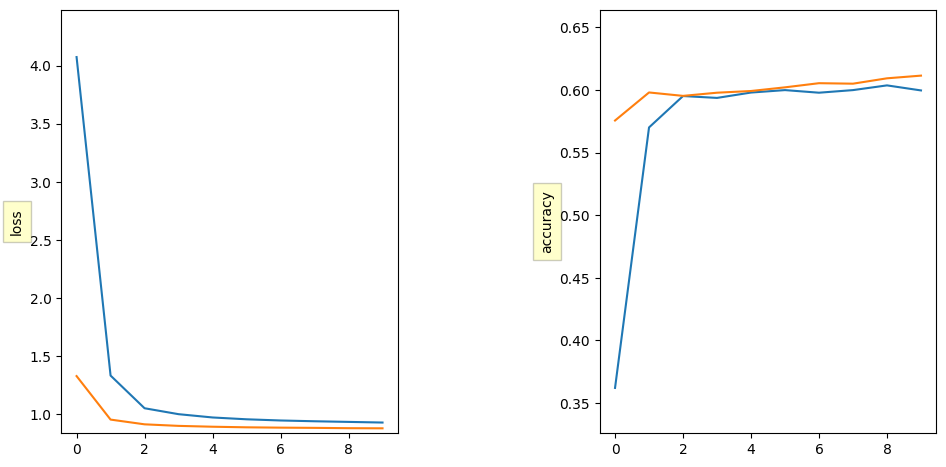

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

 barely true       0.00      0.00      0.00       429
       false       0.27      0.24      0.25       523
   half true       0.22      0.17      0.19       534
 mostly true       0.21      0.73      0.32       469
  pants fire       0.00      0.00      0.00       211
        true       0.21      0.02      0.03       402

    accuracy                           0.22      2568
   macro avg       0.15      0.19      0.13      2568
weighted avg       0.17      0.22      0.15      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


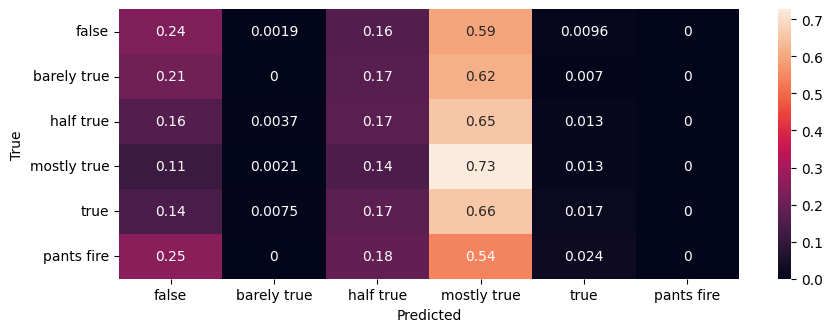

[0.25, 0.0, 0.1920668058455115, 0.3229166666666667, 0.03218390804597701, 0.0]
Class(es) with lowest f1 score: barely true
Examples of mis-classified statements:
Input: truthfulness: Says a trash mound on U.S. 290 is 800 feet tall.
Predicted class: mostly true
Input: truthfulness: The Wisconsin Retirement System for public employees is a self-funded pension plan and its the money of the workers that funds it.
Predicted class: false
Input: truthfulness: Cuccinelli wants to make all abortion illegal, even in cases of rape and incest, even to protect a womans health.
Predicted class: mostly true
Class(es) with lowest f1 score: pants fire
Examples of mis-classified statements:
Input: truthfulness: Scott Walker has a plan to privatize state lands and wants to sell our deer to the highest bidder.
Predicted class: mostly true
Input: truthfulness: Barack Obama began his presidency with an apology tour.
Predicted class: false
Input: truthfulness: Barack Obama and Hillary Clinton are negotiating 

In [47]:
evaluate_model(six_way_model, initial_six_way_history, test_labels, predictions, test_claims)

Learning Curve


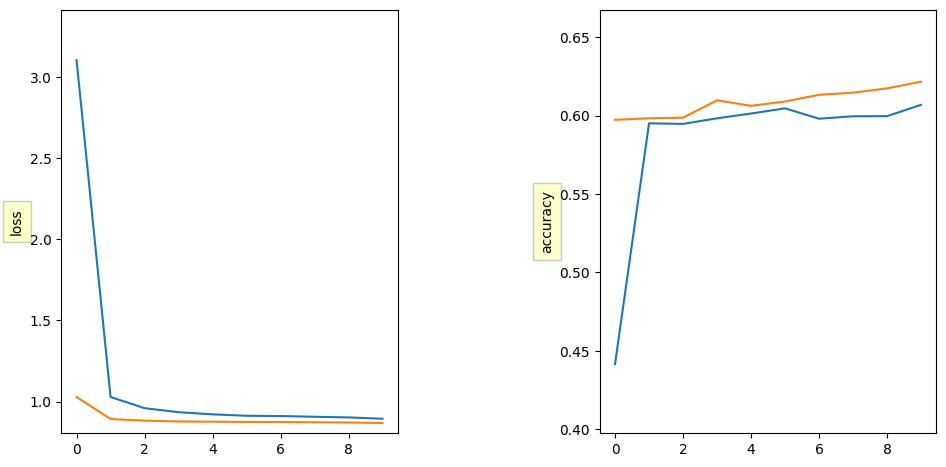

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

 barely true       0.21      0.02      0.04       429
       false       0.26      0.49      0.34       523
   half true       0.24      0.41      0.30       534
 mostly true       0.24      0.28      0.26       469
  pants fire       0.62      0.04      0.07       211
        true       0.13      0.01      0.02       402

    accuracy                           0.24      2568
   macro avg       0.28      0.21      0.17      2568
weighted avg       0.25      0.24      0.19      2568

Confusion matrix


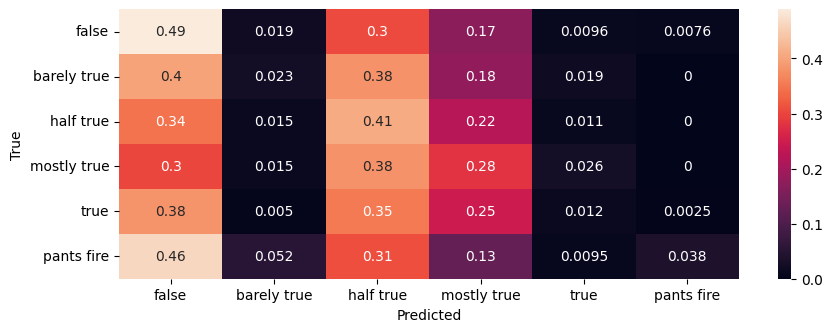

[0.3355176933158584, 0.041928721174004195, 0.2988348183687457, 0.2594059405940594, 0.022727272727272728, 0.07142857142857144]
Class(es) with lowest f1 score: true
Examples of mis-classified statements:
Input: truthfulness: Gov. Rick Scotts sale of the state planes was not proper. legal-issues state-budget jd-alexander State senator Florida
Predicted class: false
Input: truthfulness: A bill before the Georgia General Assembly would make presidential candidates meet citizenship requirements that are not in the U.S. Constitution. obama-birth-certificate loren-collins Attorney, blogger Georgia
Predicted class: false
Input: truthfulness: "Obama said his proposed $1,000 emergency energy rebate ""will be enough to offset the increased cost of gas for a working family over the next 4 months.""" energy barack-obama President Illinois
Predicted class: mostly true


In [48]:
evaluate_model(six_way_concat_model, six_way_concat_history, test_labels, predictions_comb, test_combined)

In [ ]:
# Tokenize the claim for validation data
val_claims = [x['claim'] for x in val]

val_input_ids = [t5_tokenizer(x, return_tensors = 'tf', max_length=512, truncation=True, padding='max_length') for x in val_claims]
val_input_ids = [x['input_ids'] for x in val_input_ids]

with tpu_strategy.scope():
  val_predictions = [six_way_model.generate(x).numpy()[0] for x in val_input_ids]

val_predictions = [t5_tokenizer.decode(x) for x in val_predictions]

/usr/local/lib/python3.9/dist-packages/transformers/generation/tf_utils.py:854: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [57]:
val_predictions = [x.replace('<pad> ', '').replace('</s', '').replace('>', '') for x in val_predictions]
# Printed tensorflow validation is wrong due to how tensorflow scores itself (the EOS tokens are getting credit for matching when they shouldn't). check actual val accuracy
accuracy = list(zip(val_predictions, val_labels))
numerator = [x for x in accuracy if x[0] == x[1]]
                                
print(len(accuracy))
print(len(numerator))

accuracy[0]


2567
570


('4', '4')